# Calibration of camera orientation from sun detected positions VS ephemerids

This code is meant to find the camera orientation in East-North-Up frame by fitting sun's
positions projected on the sensor, with ephemerids rotated by the camera guessed orientation. It works on full-sized images.

End user can just see how orientation calibration is done but it don't really help to use the database.

Input : "ManipeResultats" folder with heavy, big images sorted by acquisition, (not simple to use)

Output : Camera orientation values in "calib" path :
    

In [23]:

# Le but de ce programme est de trouver dans quelle orientation se trouve le capteur Sony polarisé avec son fisheye
# en comparant et en mettant en concordance les orientations successives du soleil au cours de la journée et 
# l'emplacement des "taches" correspondant à l'image du soleil.



import os
from tqdm import trange
import skimage.io
import skimage.filters

import numpy as np
from lmfit import Minimizer, Parameters, report_fit
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

path= "/scratch/lpoughon/ManipeResultats/"#Le dossier où on lit les images.
calib_path="/scratch/lpoughon/PolarizedDatabase/calib/"
dist_center=[1.215145972506110e+03,1.030433565024923e+03] #camera distorsion center, from matlab calibration

import centroide_images
import ephemeride

### Loading and sorting filenames by date

In [24]:
dirs = os.listdir( path ) # Listing all acquisitions in folder
dirs_files=[] 
for file in dirs:
    if file[-4:]=='.npy':
        dirs_files.append(file) # Keeping only numpy files
dirs_files.sort() 

sorted_filenames_dict = {}
# Populate the dictionary with the sorted filenames by date
for filename in dirs_files:
    key = filename.split('T')[0]
    if key not in sorted_filenames_dict:
        sorted_filenames_dict[key] = []
    sorted_filenames_dict[key].append(filename)
    
dates=list(sorted_filenames_dict.keys())
dates.sort()
print(dates)
choosen_date=dates[5]
print("Choosen date : ",choosen_date)

['2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29']
Choosen date :  2022-08-03


In [25]:
eph=ephemeride.ephemerides()    

### Spherical <-> Cartesian conversion

In [26]:
def cart2sph2(x,y,z):
    """
    Entree : trois tableaux numpy avec les n coordonnées selon l'axe x, y et z de n vecteurs
    Sortie : deux tableaux numpy avec les n coordonnées en azimut et elevation, en radians, avec la convention elevation  à pi/2 si vecteur selon le plan x-y, et nulle selon z.
    """
    azimuth = np.arctan2(y,x)
    elevation = np.pi/2-np.arctan2(z,np.sqrt(x**2 + y**2))
    return azimuth, elevation


def sph2cart2(azimuth,elevation):
    """
    Entree : deux tableaux numpy avec les n coordonnées en azimut et elevation, en radians, avec la convention elevation  à pi/2 si vecteur selon le plan x-y, et nulle selon z.
    Sortie : trois tableaux numpy avec les n coordonnées selon l'axe x, y et z de n vecteurs
    """
    x = np.cos(np.pi/2-elevation) * np.cos(azimuth)
    y = np.cos(np.pi/2-elevation) * np.sin(azimuth)
    z = np.sin(np.pi/2-elevation)
    return x, y, z

### Detect centroids of XY sun position on sensor on all images and give corresponding ephemerids in East-North-Up (ENU) frame, on a given date

In [27]:
def find_centroides_date(choosen_date): #detect centroids on images and give corresponding ephemerids, on a given date
    centroides=[]
    Psi_Theta_eph=[]
    init_somme_image=0

    for i_image in trange(len(dirs_files)):
        for chemins_pos in [dirs_files[i_image]]:
            chemins=np.load(path+chemins_pos)
            i_eme_image=-1
            angles_az=[]
            for chemin in chemins:#chemins_angles_raw_names:
                i_eme_image+=1
                #skip all images but not the one with lower exposure
                if i_eme_image!=5:
                    continue
                if chemin.split('T')[0][-10:]!=choosen_date: #keep only the correct date
                    continue
                png_raw_name=path+chemin.split('ManipeResultats/')[1]
                #print(png_raw_name)
                #liste_expo=np.load(png_raw_name+"liste_expo"+'.npy')
                #liste_angles=np.load(png_raw_name+"liste_angles"+'.npy')
                #taille_liste_angles=liste_angles.shape[1]#361
                #config_monture=np.load(png_raw_name+"config_monture.npy")
                (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chemin.split('ManipeResultats/')[1])
                if 90-Theta_sun<10:continue #If the sun is too low on horizon


                image=np.load(png_raw_name+str(i_eme_image)+'.npy').astype('int64')
                if init_somme_image==0:
                    init_somme_image=1
                    somme_image=image.copy()
                else:
                    somme_image=somme_image+image

                sigma=8
                image_floue= skimage.filters.gaussian(image, sigma=(sigma, sigma), truncate=3.5, channel_axis=True)
                centroide_image=centroide_images.centroide(image_floue)
                
                centroides.append(centroide_image)

                Psi_Theta_eph.append([Psi_sun,Theta_sun])

    centroides=np.array(centroides)
    Psi_Theta_eph=np.array(Psi_Theta_eph)
    return centroides,Psi_Theta_eph

### Compute angles of incoming rays corresponding to sensor's XY pixels coordinates
This function represents the optical distorsion model of the fisheye lens. 
It takes in input XY pixels coordinate to consider ('centroides'), optical distorsion center of fisheye ('x_0' and 'y_0') and focal length for our lens (in pixels, in our case ~520 pixels -> 1.8mm)
It output 3d vector of corresponding incoming ray conjugated with XY pixel on sensor, in spherical coordinates in radians, in camera frame.
(Psi : Azimut, Theta : Incidence Angle in respcet to optical axis)

In [28]:
def calcul_Psi_Theta_Mes(centroides,x_0,y_0,f):
    theta2=(np.hypot(((centroides[:,1]-y_0)),((centroides[:,0]-x_0)))/f)
    alpha2=np.arctan2((centroides[:,0]-x_0),(centroides[:,1]-y_0))
    Psi_Theta_mes2=np.array([alpha2,theta2]).T
    return Psi_Theta_mes2

### Function to minimize to estimate rotation matrix between ENU and Camera frame

In [29]:
def myfcn2min(params,centroides,PTe,x_0,y_0):#, x, data):

    """define objective function: returns the array to be minimized.
    
    We are here seeking to evaluate, for a given set of parameters (optical center x_0 and y_0 of the 2D sensor, 
    and the three rotations alpha/beta/gamma of the fisheye+sensor assembly with respect to the ENU frame), 
    the distances between the measured points of the sensor that are translated into incident sun rays orientation, 
    and the theoretical orientations from the ephemeris. It returns a error vector of size 1*n where n is the number 
    of incident measurements.
    
    """
    
    alpha=params['alpha']
    beta=params['beta']
    gamma=params['gamma']
    f = params['f']

    PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f)#,XCoeff,YCoeff)
    
    r = R.from_euler('ZXY',[alpha+0,beta+0,gamma+0],degrees=True)
    PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
    PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T


    diff=np.array(sph2cart2(PTe[:,0],PTe[:,1])).T-np.array(sph2cart2(PT_rot[:,0],PT_rot[:,1])).T
    somme=diff[:,0]**2+diff[:,1]**2+diff[:,2]**2

    return somme

### Do the fit and eventually save its parameters

In [30]:
def fit_centroides_PTe(centroides,PTe,dist_center,save_ENU=False):

    afficher_listing=False 

    # create a set of Parameters
    params = Parameters()

    params.add('alpha', value=0, min=-360, max=360)
    params.add('beta', value=0, min=-20, max=20)
    params.add('gamma', value=-0, min=-180, max=180)
    
    # Parameters from Matlab Camera Toolbox calibration
    A=[5.141286527484923e+02,-7.116718095945076e-04,3.985956960008606e-07,-5.221100719519486e-10] 
    #dist_center=[1.215145972506110e+03,1.030433565024923e+03]

    x_0,y_0=dist_center[0],dist_center[1]
    f_start=A[0]
    
    params.add('f', value=f_start, min=f_start-100.0, max=f_start+100.0)

    f_hist=[]
    alpha_hist=[]
    beta_hist=[]
    gamma_hist=[]
    x_0_hist=[]
    y_0_hist=[]
    somme_hist=[]

    PTe=np.array(PTe)*np.pi/180


    # do fit, here with the default leastsq algorithm
    minner = Minimizer(myfcn2min, params, fcn_args=(centroides,PTe,x_0,y_0))#, data))
    result = minner.minimize(method='least_squares',max_nfev=20000000,xtol=1e-10,ftol=1e-10)
    # write error report
    print_report_fit=True
    if print_report_fit:
        report_fit(result)
    alpha=result.params.valuesdict()['alpha']
    beta=result.params.valuesdict()['beta']
    gamma=result.params.valuesdict()['gamma']
    f=result.params.valuesdict()['f']

    PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f)

    r = R.from_euler('ZXY',[alpha+0,beta+0,gamma+0],degrees=True)
    PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
    PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T

    PTe_rep_cam_cart=r.inv().apply(np.array(sph2cart2(PTe[:,0],PTe[:,1])).T).T
    PTe_rep_cam=np.array(cart2sph2(PTe_rep_cam_cart[0,:],PTe_rep_cam_cart[1,:],PTe_rep_cam_cart[2,:])).T
    centroides_eph=np.column_stack((np.sin(PTe_rep_cam[:,0])*f*PTe_rep_cam[:,1]+x_0,np.cos(PTe_rep_cam[:,0])*f*PTe_rep_cam[:,1]+y_0))

    

    if save_ENU:
        print("Save params !")
        print(calib_path)
        shape_image=(1024*2,1224*2)

        coords_image=[]
        for i in range(shape_image[0]):
            for j in range(shape_image[1]):
                coords_image.append([j,i])
        coords_image=np.array(coords_image)


        orientation_pixels=calcul_Psi_Theta_Mes(coords_image,x_0,y_0,f)
        
        OP_rot_cart=r.apply(np.array(sph2cart2(orientation_pixels[:,0],orientation_pixels[:,1])).T).T
        OP_rot=np.array(cart2sph2(OP_rot_cart[0,:],OP_rot_cart[1,:],OP_rot_cart[2,:])).T
        orientation_pixels_ENU=OP_rot.reshape((shape_image[0],shape_image[1],2))


        np.save(calib_path+'rotation.npy',r.as_euler('ZXY',degrees=True))
        np.save(calib_path+'rot_mat.npy',r.as_matrix())
        np.save(calib_path+'orientation_pixels_ENU.npy',orientation_pixels_ENU)
        np.save(calib_path+'f.npy',np.array(f))
        np.save(calib_path+'dist_center.npy',np.array(dist_center))
        lat=43.286990365824785
        lon=5.403361407820939
        np.save(calib_path+"lat_lon.npy",np.array([lat,lon]))
        print("Saved !")
        
    return r,centroides_eph,f

Process all days

In [31]:
from tqdm import tqdm
from p_tqdm import p_map

#liste_resultats=[]

def process_date(choosen_date):
    centroides,PTe=find_centroides_date(choosen_date)
    if centroides.shape[0]<=3:return [None]
    r,centroides_eph,f=fit_centroides_PTe(centroides,PTe,save_ENU=False,dist_center=dist_center)
    print(r.as_euler('ZXY',degrees=True))

    diff=centroides-centroides_eph
    somme=diff[:,0]**2+diff[:,1]**2#+diff[:,2]**2
    print(np.sum(somme))

    return [choosen_date,r.as_euler('ZXY',degrees=True),np.sum(np.abs(centroides-centroides_eph)),f]
    
num_processes=32
liste_resultats = (p_map(process_date ,dates,num_cpus=num_processes,tqdm=tqdm)) #[15000:15500:10]
liste_resultats = np.array([sublist for sublists in liste_resultats for sublist in sublists if sublist is not None])

#for choosen_date in dates:
#    print(choosen_date)
#liste_resultats=np.array(liste_resultats)
liste_resultats=liste_resultats.reshape(liste_resultats.shape[0]//4,4)
print(liste_resultats.shape)
print(liste_resultats)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4243/4243 [00:48<00:00, 86.75it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 67
    # data points      = 60
    # variables        = 4
    chi-square         = 1.6677e-10
    reduced chi-square = 2.9780e-12
    Akaike info crit   = -1588.52492
    Bayesian info crit = -1580.14755
[[Variables]]
    alpha: -135.746210 +/- 0.01565815 (0.01%) (init = 0)
    beta:   0.98782570 +/- 0.01116000 (1.13%) (init = 0)
    gamma:  2.17118436 +/- 0.01164301 (0.54%) (init = 0)
    f:      519.856178 +/- 0.06633521 (0.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  = +0.5434
    C(gamma, f)     = +0.3721
    C(alpha, gamma) = -0.3497
    C(beta, f)      = +0.3232
[-135.74621047    0.9878257     2.17118436]
22.50877692254205


 26%|██████████████████████████████████████████▊                                                                                                                       | 1122/4243 [00:51<11:28,  4.53it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 398
    # data points      = 52
    # variables        = 4
    chi-square         = 3.45557891
    reduced chi-square = 0.07199123
    Akaike info crit   = -132.985193
    Bayesian info crit = -125.180218
[[Variables]]
    alpha: -130.543638 +/- 13.4920854 (10.34%) (init = 0)
    beta:   18.0201634 +/- 5.54579114 (30.78%) (init = 0)
    gamma:  12.4554054 +/- 7.16204655 (57.50%) (init = 0)
    f:      614.128653 +/- 45.1896024 (7.36%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, gamma) = -0.7203
    C(alpha, beta)  = +0.6057
    C(beta, gamma)  = -0.5271
    C(beta, f)      = -0.2992
    C(gamma, f)     = +0.2423
[-130.54363833   18.02016337   12.45540541]
3046834.1581260357


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2889/4243 [00:55<00:01, 1021.51it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 170
    # data points      = 59
    # variables        = 4
    chi-square         = 5.6816e-10
    reduced chi-square = 1.0330e-11
    Akaike info crit   = -1488.60322
    Bayesian info crit = -1480.29307
[[Variables]]
    alpha: -135.763751 +/- 0.03166811 (0.02%) (init = 0)
    beta:   0.99788846 +/- 0.02072288 (2.08%) (init = 0)
    gamma:  2.13497977 +/- 0.01837180 (0.86%) (init = 0)
    f:      519.621145 +/- 0.09679721 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  = +0.6960
    C(beta, f)      = +0.5762
    C(alpha, gamma) = -0.3119
    C(gamma, f)     = +0.2688
    C(alpha, f)     = +0.1789


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3000/4243 [00:55<00:01, 1045.64it/s]

[-135.76375056    0.99788846    2.13497977]
34.70659897607287


 27%|███████████████████████████████████████████                                                                                                                      | 1134/4243 [00:56<00:14, 216.92it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 97
    # data points      = 60
    # variables        = 4
    chi-square         = 5.3119e-09
    reduced chi-square = 9.4855e-11
    Akaike info crit   = -1380.85977
    Bayesian info crit = -1372.48239
[[Variables]]
    alpha: -135.308077 +/- 0.02166157 (0.02%) (init = 0)
    beta:   0.12309407 +/- 0.03107637 (25.25%) (init = 0)
    gamma:  2.40551573 +/- 0.02581337 (1.07%) (init = 0)
    f:      519.851047 +/- 0.30644535 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.4800
    C(alpha, f)     = -0.3770
    C(alpha, gamma) = -0.1688
    C(beta, gamma)  = +0.1556
    C(beta, f)      = +0.1545
    C(alpha, beta)  = -0.1119

  5%|███████▋                                                                                                                                                           | 201/4243 [00:56<24:09,  2.79it/s]

 31%|██████████████████████████████████████████████████▏                                                                                                              | 1323/4243 [00:56<00:21, 133.10it/s]

[-1.35308077e+02  1.23094067e-01  2.40551573e+00]
156.83674673486928


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3985/4243 [00:58<00:02, 99.56it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 83
    # data points      = 69
    # variables        = 4
    chi-square         = 23.8509957
    reduced chi-square = 0.36693840
    Akaike info crit   = -65.2973571
    Bayesian info crit = -56.3609311
[[Variables]]
    alpha: -138.668674 +/- 13.3756042 (9.65%) (init = 0)
    beta:  -5.41655187 +/- 9.62058813 (177.61%) (init = 0)
    gamma:  17.8786819 +/- 9.37119956 (52.42%) (init = 0)
    f:      614.128653 +/- 55.6694980 (9.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, gamma) = -0.4429
    C(beta, gamma)  = +0.3396
    C(beta, f)      = +0.2816
    C(alpha, beta)  = +0.2076
[-138.6686742    -5.41655187   17.87868189]

 55%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2353/4243 [00:58<00:01, 977.49it/s]


9497007.994589094


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3489/4243 [00:59<00:00, 897.62it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 790
    # data points      = 64
    # variables        = 4
    chi-square         = 0.00419094
    reduced chi-square = 6.9849e-05
    Akaike info crit   = -608.557683
    Bayesian info crit = -599.922150
[[Variables]]
    alpha: -133.441689 +/- 1.24206996 (0.93%) (init = 0)
    beta:  -1.16889671 +/- 2.44713785 (209.35%) (init = 0)
    gamma:  2.08828732 +/- 3.28498178 (157.31%) (init = 0)
    f:      502.135343 +/- 9.77411353 (1.95%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  = +0.8397
    C(alpha, beta)  = +0.5736
    C(gamma, f)     = +0.5724
    C(alpha, gamma) = +0.3859
    C(alpha, f)     = +0.2496
    C(beta, f)      = +0.1905


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3817/4243 [00:59<00:18, 22.71it/s]

[-133.44168929   -1.16889671    2.08828732]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2677/4243 [00:59<00:01, 829.86it/s]

79413.84510109544


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4041/4243 [00:59<00:00, 1042.25it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 123
    # data points      = 64
    # variables        = 4
    chi-square         = 3.1472e-09
    reduced chi-square = 5.2454e-11
    Akaike info crit   = -1511.07996
    Bayesian info crit = -1502.44443
[[Variables]]
    alpha: -135.709210 +/- 0.04375547 (0.03%) (init = 0)
    beta:   0.89304106 +/- 0.02884406 (3.23%) (init = 0)
    gamma:  2.20643262 +/- 0.02855256 (1.29%) (init = 0)
    f:      519.451594 +/- 0.20498958 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.6465
    C(alpha, f)     = -0.4387
    C(beta, gamma)  = +0.3549
    C(alpha, gamma) = -0.2722
    C(beta, f)      = -0.1006

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3003/4243 [00:59<00:01, 1005.40it/s]


[-135.7092099     0.89304106    2.20643262]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3225/4243 [00:59<00:00, 1059.45it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1086
    # data points      = 64
    # variables        = 4
    chi-square         = 0.09510774
    reduced chi-square = 0.00158513
    Akaike info crit   = -408.744193
    Bayesian info crit = -400.108661
[[Variables]]
    alpha: -127.168868 +/- 1.94677283 (1.53%) (init = 0)
    beta:  -1.50891729 +/- 2.85099294 (188.94%) (init = 0)
    gamma:  0.56178407 +/- 2.60288060 (463.32%) (init = 0)
    f:      533.082405 +/- 26.5578884 (4.98%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.7299
    C(alpha, f)     = -0.2799
    C(beta, f)      = -0.1593
    C(alpha, gamma) = -0.1293
    C(beta, gamma)  = -0.1260

68.07555980582607[-127.16886777   -1.50891729    0.56178407]
536910.5404281734


 50%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2127/4243 [00:59<01:21, 26.12it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3467/4243 [00:59<00:02, 286.25it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 434
    # data points      = 67
    # variables        = 4
    chi-square         = 5.0520e-09
    reduced chi-square = 8.0191e-11
    Akaike info crit   = -1553.64758
    Bayesian info crit = -1544.82881
[[Variables]]
    alpha: -135.430815 +/- 0.02105366 (0.02%) (init = 0)
    beta:   0.23244717 +/- 0.02822956 (12.14%) (init = 0)
    gamma:  2.30015236 +/- 0.02346314 (1.02%) (init = 0)
    f:      519.713349 +/- 0.26573537 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.4911
    C(alpha, f)     = -0.4786
    C(beta, f)      = +0.3295
    C(alpha, beta)  = -0.2798
    C(alpha, gamma) = -0.2261
    C(beta, gamma)  = +0.1783
[-135.43081461    0.23244717    2.30015236]
163.677087343776


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3110/4243 [00:59<00:01, 918.69it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 438
    # data points      = 66
    # variables        = 4
    chi-square         = 6.3043e-09
    reduced chi-square = 1.0168e-10
    Akaike info crit   = -1514.73130
    Bayesian info crit = -1505.97269
[[Variables]]
    alpha: -135.337378 +/- 0.02116735 (0.02%) (init = 0)
    beta:   0.13655855 +/- 0.03180049 (23.29%) (init = 0)
    gamma:  2.40062393 +/- 0.02403664 (1.00%) (init = 0)
    f:      519.704862 +/- 0.32641067 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)     = +0.4242
    C(alpha, f)    = -0.4000
    C(gamma, f)    = +0.3999
    C(alpha, beta) = -0.2445
[-135.33737782    0.13655855    2.40062393]


 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                 | 2124/4243 [00:59<08:13,  4.30it/s]

181.22866830580722


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2971/4243 [01:00<04:12,  5.04it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 581
    # data points      = 68
    # variables        = 4
    chi-square         = 8.0115e-09
    reduced chi-square = 1.2518e-10
    Akaike info crit   = -1546.60883
    Bayesian info crit = -1537.73080
[[Variables]]
    alpha: -135.315996 +/- 0.02127237 (0.02%) (init = 0)
    beta:   0.08898540 +/- 0.02920599 (32.82%) (init = 0)
    gamma:  2.39238382 +/- 0.02632563 (1.10%) (init = 0)
    f:      519.752799 +/- 0.31823709 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.4870
    C(alpha, f)     = -0.3559
    C(beta, f)      = +0.2178
    C(alpha, gamma) = -0.1646
    C(alpha, beta)  = -0.1562
    C(beta, gamma)  = +0.1491
[-1.35315996e+02  8.89853970e-02  2.39238382e+00]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2454/4243 [01:00<01:04, 27.86it/s]

211.79403603147387


 42%|████████████████████████████████████████████████████████████████████                                                                                              | 1784/4243 [01:00<01:23, 29.28it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 253
    # data points      = 64
    # variables        = 4
    chi-square         = 8.5977e-08
    reduced chi-square = 1.4330e-09
    Akaike info crit   = -1299.39624
    Bayesian info crit = -1290.76070
[[Variables]]
    alpha: -135.457360 +/- 0.06117761 (0.05%) (init = 0)
    beta:   0.34953647 +/- 0.05251229 (15.02%) (init = 0)
    gamma:  2.13917217 +/- 0.05600949 (2.62%) (init = 0)
    f:      519.890112 +/- 0.35898106 (0.07%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  = +0.4039
    C(gamma, f)     = +0.3405
    C(alpha, gamma) = -0.2027
    C(alpha, beta)  = +0.1882
[-135.45736009    0.34953647    2.13917217]
475.8899416051853


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3585/4243 [01:00<00:09, 72.34it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 210
    # data points      = 61
    # variables        = 4
    chi-square         = 1.5888e-09
    reduced chi-square = 2.7873e-11
    Akaike info crit   = -1478.64220
    Bayesian info crit = -1470.19870
[[Variables]]
    alpha: -135.717791 +/- 0.03333917 (0.02%) (init = 0)
    beta:   0.97530657 +/- 0.02620037 (2.69%) (init = 0)
    gamma:  2.15364525 +/- 0.02522827 (1.17%) (init = 0)
    f:      519.619905 +/- 0.15261938 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  = +0.6645
    C(beta, f)      = +0.5596
    C(alpha, f)     = +0.4774
    C(gamma, f)     = +0.3330
    C(alpha, gamma) = +0.1160
[-135.71779053    0.97530657    2.15364525]
56.51588811741833


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4202/4243 [01:00<00:00, 931.59it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 487
    # data points      = 64
    # variables        = 4
    chi-square         = 5.2937e-09
    reduced chi-square = 8.8228e-11
    Akaike info crit   = -1477.80033
    Bayesian info crit = -1469.16479
[[Variables]]
    alpha: -135.346775 +/- 0.02070729 (0.02%) (init = 0)
    beta:   0.18049889 +/- 0.02895487 (16.04%) (init = 0)
    gamma:  2.38900723 +/- 0.02396470 (1.00%) (init = 0)
    f:      519.751967 +/- 0.27208763 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.4852
    C(alpha, f)     = -0.3865
    C(beta, f)      = +0.2189
    C(beta, gamma)  = +0.2028
    C(alpha, gamma) = -0.1872
    C(alpha, beta)  = -0.1856
[-135.34677475    0.18049889    2.38900723]
166.01856844922543

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3190/4243 [01:00<00:02, 519.46it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3434/4243 [01:01<00:01, 492.76it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 407
    # data points      = 67
    # variables        = 4
    chi-square         = 7.5441e-09
    reduced chi-square = 1.1975e-10
    Akaike info crit   = -1526.78223
    Bayesian info crit = -1517.96346
[[Variables]]
    alpha: -135.191235 +/- 0.02120089 (0.02%) (init = 0)
    beta:   0.29094677 +/- 0.02703124 (9.29%) (init = 0)
    gamma:  2.46097532 +/- 0.02856295 (1.16%) (init = 0)
    f:      519.249561 +/- 0.30952754 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.5080
    C(alpha, gamma) = +0.1963


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4029/4243 [01:01<00:00, 259.78it/s]

[-135.19123537    0.29094677    2.46097532]
188.9389999193001


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3612/4243 [01:01<00:00, 795.36it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 136
    # data points      = 64
    # variables        = 4
    chi-square         = 3.8984e-08
    reduced chi-square = 6.4974e-10
    Akaike info crit   = -1350.01514
    Bayesian info crit = -1341.37960
[[Variables]]
    alpha: -135.699334 +/- 0.08956326 (0.07%) (init = 0)
    beta:   0.97005604 +/- 0.08438932 (8.70%) (init = 0)
    gamma:  2.39406799 +/- 0.06588408 (2.75%) (init = 0)
    f:      519.234902 +/- 0.38665204 (0.07%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  = +0.7406
    C(alpha, f)     = -0.5268
    C(beta, f)      = +0.5198
    C(alpha, gamma) = -0.5030
    C(gamma, f)     = +0.4069
    C(alpha, beta)  = -0.2574


 59%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2503/4243 [01:01<00:05, 299.03it/s]

[-135.69933446    0.97005604    2.39406799]
216.36338978738104


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4192/4243 [01:01<00:00, 1116.14it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 131
    # data points      = 67
    # variables        = 4
    chi-square         = 3.3583e-09
    reduced chi-square = 5.3306e-11
    Akaike info crit   = -1581.00746
    Bayesian info crit = -1572.18869
[[Variables]]
    alpha: -135.490486 +/- 0.01849625 (0.01%) (init = 0)
    beta:   0.27623462 +/- 0.02143217 (7.76%) (init = 0)
    gamma:  2.23298496 +/- 0.02129113 (0.95%) (init = 0)
    f:      519.362569 +/- 0.19581336 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)    = +0.5473
    C(beta, f)     = +0.2230
    C(beta, gamma) = +0.1575
    C(alpha, beta) = -0.1020
[-135.49048567    0.27623462    2.23298496]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3114/4243 [01:01<00:01, 838.43it/s]


125.58940844116476

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4243/4243 [01:02<00:00, 68.43it/s]



[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 128
    # data points      = 67
    # variables        = 4
    chi-square         = 1.4205e-08
    reduced chi-square = 2.2548e-10
    Akaike info crit   = -1484.38206
    Bayesian info crit = -1475.56329
[[Variables]]
    alpha: -135.409665 +/- 0.03339712 (0.02%) (init = 0)
    beta:   0.30386007 +/- 0.03888492 (12.80%) (init = 0)
    gamma:  2.24029576 +/- 0.03995975 (1.78%) (init = 0)
    f:      520.276056 +/- 0.30709080 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.4991
    C(alpha, gamma) = -0.4616
    C(beta, f)      = -0.2680
    C(beta, gamma)  = +0.2224
    C(alpha, f)     = -0.2085
    C(alpha, beta)  = -0.1220

 47%|████████████████████████████████████████████████████████████████████████████                                                                                     | 2005/4243 [01:02<00:07, 312.54it/s]


[-135.40966481    0.30386007    2.24029576]
203.94748176316324


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3116/4243 [01:03<00:00, 1139.52it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 518
    # data points      = 66
    # variables        = 4
    chi-square         = 4.9879e-09
    reduced chi-square = 8.0450e-11
    Akaike info crit   = -1530.18985
    Bayesian info crit = -1521.43123
[[Variables]]
    alpha: -135.404721 +/- 0.01946137 (0.01%) (init = 0)
    beta:   0.23991999 +/- 0.02674820 (11.15%) (init = 0)
    gamma:  2.32324101 +/- 0.02222046 (0.96%) (init = 0)
    f:      519.609388 +/- 0.25703015 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)     = +0.4092
    C(alpha, f)    = -0.3639
    C(gamma, f)    = +0.3325
    C(alpha, beta) = -0.1620
[-135.40472098    0.23991999    2.32324101]
167.34573891588522


 27%|████████████████████████████████████████████▏                                                                                                                     | 1158/4243 [01:03<12:49,  4.01it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 146
    # data points      = 64
    # variables        = 4
    chi-square         = 5.1592e-09
    reduced chi-square = 8.5987e-11
    Akaike info crit   = -1479.44731
    Bayesian info crit = -1470.81178
[[Variables]]
    alpha: -135.699671 +/- 0.02775878 (0.02%) (init = 0)
    beta:   1.05077197 +/- 0.02584817 (2.46%) (init = 0)
    gamma:  2.28939511 +/- 0.03082039 (1.35%) (init = 0)
    f:      520.173008 +/- 0.25820948 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.5759
    C(alpha, beta)  = +0.2792
    C(beta, f)      = +0.1819
    C(alpha, gamma) = +0.1143
[-135.69967116    1.05077197    2.28939511]

 31%|██████████████████████████████████████████████████▌                                                                                                               | 1323/4243 [01:03<09:36,  5.07it/s]


106.84766737594657


 53%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2267/4243 [01:04<08:07,  4.05it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1037
    # data points      = 69
    # variables        = 4
    chi-square         = 6.0845e-05
    reduced chi-square = 9.3608e-07
    Akaike info crit   = -953.948891
    Bayesian info crit = -945.012465
[[Variables]]
    alpha: -134.584157 +/- 0.89794505 (0.67%) (init = 0)
    beta:   0.78555819 +/- 0.68452565 (87.14%) (init = 0)
    gamma:  2.07175038 +/- 0.62446011 (30.14%) (init = 0)
    f:      527.438869 +/- 7.03218497 (1.33%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = -0.8390
    C(gamma, f)     = +0.8214
    C(alpha, gamma) = -0.8208
    C(beta, f)      = -0.5539
    C(alpha, beta)  = +0.1950
[-134.58415745    0.78555819    2.07175038]
9764.671357894997


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2966/4243 [01:05<00:05, 221.44it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 169
    # data points      = 69
    # variables        = 4
    chi-square         = 8.5988e-05
    reduced chi-square = 1.3229e-06
    Akaike info crit   = -930.082938
    Bayesian info crit = -921.146512
[[Variables]]
    alpha: -133.861461 +/- 0.44201672 (0.33%) (init = 0)
    beta:   0.73513970 +/- 0.97044826 (132.01%) (init = 0)
    gamma:  2.84629545 +/- 0.35325558 (12.41%) (init = 0)
    f:      523.554000 +/- 5.10886203 (0.98%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = -0.6923
    C(alpha, f)     = -0.6897
    C(beta, f)      = +0.5859
    C(alpha, gamma) = -0.4408
    C(beta, gamma)  = +0.1067
[-133.86146059    0.7351397     2.84629545]
14560.122995661337


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4243/4243 [01:06<00:00, 63.81it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 87
    # data points      = 63
    # variables        = 4
    chi-square         = 1.5351e-10
    reduced chi-square = 2.6018e-12
    Akaike info crit   = -1676.64573
    Bayesian info crit = -1668.07319
[[Variables]]
    alpha: -135.680289 +/- 0.01362854 (0.01%) (init = 0)
    beta:   0.95824771 +/- 0.01089139 (1.14%) (init = 0)
    gamma:  2.22837907 +/- 0.01179310 (0.53%) (init = 0)
    f:      519.901626 +/- 0.06643958 (0.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = +0.5721
    C(beta, f)     = +0.4111
    C(alpha, beta) = +0.3290
    C(gamma, f)    = +0.3050
    C(alpha, f)    = +0.2809
[-135.68028888    0.95824771    2.22837907]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4164/4243 [01:06<00:00, 1209.10it/s]

21.62536610651939


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2514/4243 [01:06<00:15, 108.20it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 170
    # data points      = 68
    # variables        = 4
    chi-square         = 2.0126e-08
    reduced chi-square = 3.1447e-10
    Akaike info crit   = -1483.97102
    Bayesian info crit = -1475.09299
[[Variables]]
    alpha: -135.393589 +/- 0.03001973 (0.02%) (init = 0)
    beta:   0.34591050 +/- 0.04527984 (13.09%) (init = 0)
    gamma:  2.43039554 +/- 0.03594068 (1.48%) (init = 0)
    f:      519.672745 +/- 0.48504885 (0.09%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)     = +0.5982
    C(alpha, f)    = -0.3991
    C(alpha, beta) = -0.3281
    C(gamma, f)    = +0.1841[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 632
    # data points      = 70
    # variables        = 4
    chi-square         = 7.89433839
    reduced chi-square = 0.11961119
    Akaike info crit   = -144.764458
    Bayesian info crit = -135.770477
[[Va

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3534/4243 [01:06<00:01, 658.31it/s]

[-135.39358939    0.3459105     2.43039554]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4243/4243 [01:06<00:00, 63.70it/s]

276.90541797043625



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3768/4243 [01:06<00:00, 823.82it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 448
    # data points      = 70
    # variables        = 4
    chi-square         = 5.0601e-09
    reduced chi-square = 7.6669e-11
    Akaike info crit   = -1626.52561
    Bayesian info crit = -1617.53163
[[Variables]]
    alpha: -135.404195 +/- 0.02055312 (0.02%) (init = 0)
    beta:   0.24604616 +/- 0.02650551 (10.77%) (init = 0)
    gamma:  2.35172006 +/- 0.02073316 (0.88%) (init = 0)
    f:      519.805148 +/- 0.22342168 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.4488
    C(alpha, f)     = -0.4381
    C(alpha, gamma) = -0.2287
    C(beta, f)      = +0.1973
    C(beta, gamma)  = +0.1772
    C(alpha, beta)  = -0.1563
[-135.40419466    0.24604616    2.35172006]
164.0311711758408


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2443/4243 [01:07<05:05,  5.89it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 639
    # data points      = 66
    # variables        = 4
    chi-square         = 0.00300837
    reduced chi-square = 4.8522e-05
    Akaike info crit   = -651.736701
    Bayesian info crit = -642.978082
[[Variables]]
    alpha: -133.374877 +/- 2.64076285 (1.98%) (init = 0)
    beta:   2.32348165 +/- 1.82978488 (78.75%) (init = 0)
    gamma:  4.84970395 +/- 1.66930145 (34.42%) (init = 0)
    f:      536.614527 +/- 14.9147730 (2.78%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, gamma) = -0.9244
    C(alpha, f)     = -0.8780
    C(gamma, f)     = +0.7370
    C(beta, f)      = +0.4694
    C(alpha, beta)  = -0.4657
    C(beta, gamma)  = +0.4312
[-133.37487709    2.32348165    4.84970395]
79195.180072328


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3211/4243 [01:08<00:09, 104.24it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 117
    # data points      = 70
    # variables        = 4
    chi-square         = 1.4985e-08
    reduced chi-square = 2.2704e-10
    Akaike info crit   = -1550.53180
    Bayesian info crit = -1541.53782
[[Variables]]
    alpha: -135.489833 +/- 0.03260136 (0.02%) (init = 0)
    beta:   0.22109971 +/- 0.03909371 (17.68%) (init = 0)
    gamma:  2.25825721 +/- 0.02627630 (1.16%) (init = 0)
    f:      519.499232 +/- 0.30638835 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.5904
    C(alpha, beta)  = -0.3608
    C(alpha, f)     = -0.3376
    C(gamma, f)     = +0.3072
    C(beta, gamma)  = +0.2262
    C(alpha, gamma) = -0.1633
[-135.489833      0.22109971    2.25825721]
229.08698194136582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4243/4243 [01:08<00:00, 61.65it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 450
    # data points      = 69
    # variables        = 4
    chi-square         = 1.5839e-07
    reduced chi-square = 2.4367e-09
    Akaike info crit   = -1364.57033
    Bayesian info crit = -1355.63391
[[Variables]]
    alpha: -135.569494 +/- 0.07644343 (0.06%) (init = 0)
    beta:   0.21871552 +/- 0.06145525 (28.10%) (init = 0)
    gamma:  2.16298981 +/- 0.05514494 (2.55%) (init = 0)
    f:      519.874903 +/- 0.50988236 (0.10%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)     = +0.6769
    C(beta, gamma) = +0.2594
[-135.56949428    0.21871552    2.16298981]
633.8504409466801


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4243/4243 [01:10<00:00, 60.17it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 314
    # data points      = 69
    # variables        = 4
    chi-square         = 1.1653e-08
    reduced chi-square = 1.7927e-10
    Akaike info crit   = -1544.62596
    Bayesian info crit = -1535.68953
[[Variables]]
    alpha: -135.643290 +/- 0.10042837 (0.07%) (init = 0)
    beta:   0.88295738 +/- 0.04602606 (5.21%) (init = 0)
    gamma:  2.18224310 +/- 0.05755286 (2.64%) (init = 0)
    f:      519.498528 +/- 0.24619084 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  = +0.5559
    C(gamma, f)     = +0.4810
    C(beta, f)      = -0.2090
    C(alpha, gamma) = -0.1873
    C(alpha, f)     = -0.1505
[-135.6432899     0.88295738    2.1822431 ]
93.31512818554404


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4243/4243 [01:11<00:00, 59.12it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 589
    # data points      = 69
    # variables        = 4
    chi-square         = 8.91648961
    reduced chi-square = 0.13717676
    Akaike info crit   = -133.188088
    Bayesian info crit = -124.251662
[[Variables]]
    alpha: -118.748198 +/- 8.77033071 (7.39%) (init = 0)
    beta:   12.9502028 +/- 12.1592334 (93.89%) (init = 0)
    gamma: -26.1674596 +/- 8.23320690 (31.46%) (init = 0)
    f:      476.160865 +/- 53.6282301 (11.26%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  = +0.8929
    C(gamma, f)     = +0.8133
    C(beta, f)      = +0.8078
    C(alpha, beta)  = -0.3314
    C(alpha, f)     = -0.3310
    C(alpha, gamma) = -0.2117
[-118.74819807   12.95020279  -26.16745956]
4935870.98150198


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:12<00:00,  2.25s/it]

(31, 4)
[['2022-07-29' array([-130.54363833,   18.02016337,   12.45540541])
  14121.437370568034 614.1286526773563]
 ['2022-07-30' array([-135.19123537,    0.29094677,    2.46097532])
  131.16318554389522 519.2495609479361]
 ['2022-07-31' array([-1.35315996e+02,  8.89853970e-02,  2.39238382e+00])
  141.3545324345373 519.7527993114827]
 ['2022-08-01' array([-1.35308077e+02,  1.23094067e-01,  2.40551573e+00])
  110.89661001229956 519.8510471545185]
 ['2022-08-02' array([-135.33737782,    0.13655855,    2.40062393])
  127.8550609169996 519.7048619581755]
 ['2022-08-03' array([-135.34677475,    0.18049889,    2.38900723])
  122.07245868017202 519.7519669310274]
 ['2022-08-04' array([-133.86146059,    0.7351397 ,    2.84629545])
  1080.6644425026254 523.5540004733826]
 ['2022-08-05' array([-134.58415745,    0.78555819,    2.07175038])
  878.8616081044036 527.4388690418148]
 ['2022-08-06' array([-135.40419466,    0.24604616,    2.35172006])
  125.85984069188885 519.805148294879]
 ['2022-08-0


/tmp/ipykernel_241213/1400192948.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  liste_resultats = np.array([sublist for sublists in liste_resultats for sublist in sublists if sublist is not None])


Plot Z,X,Y rotation values estimated for different days

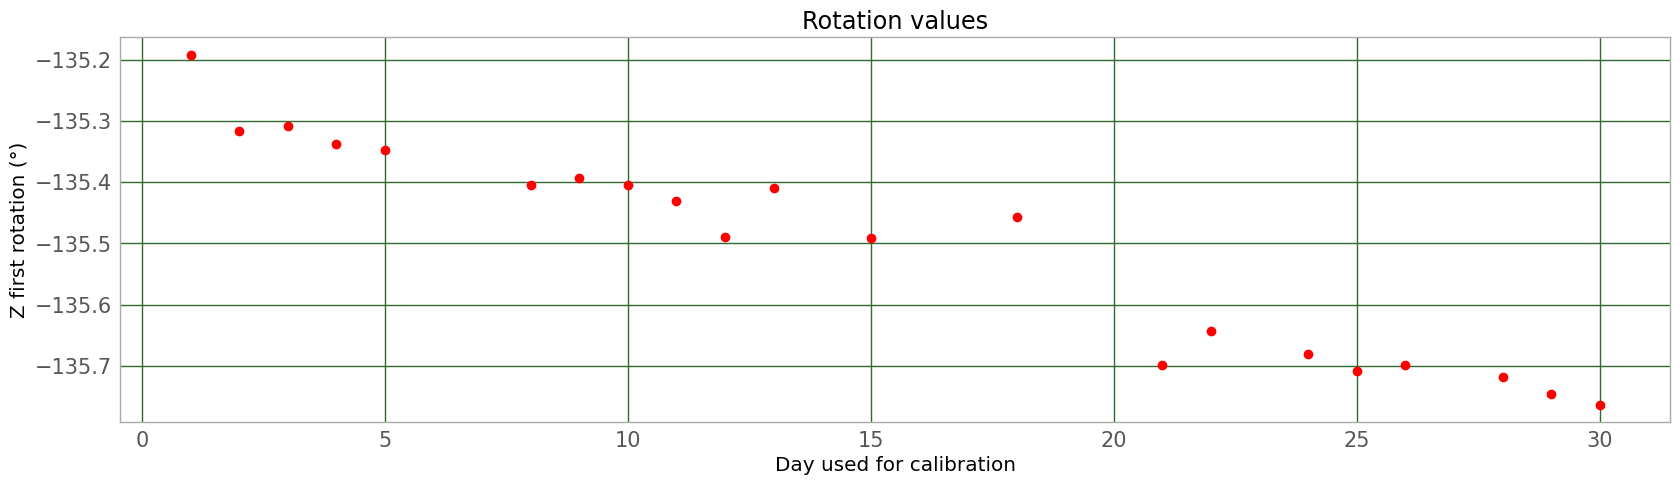

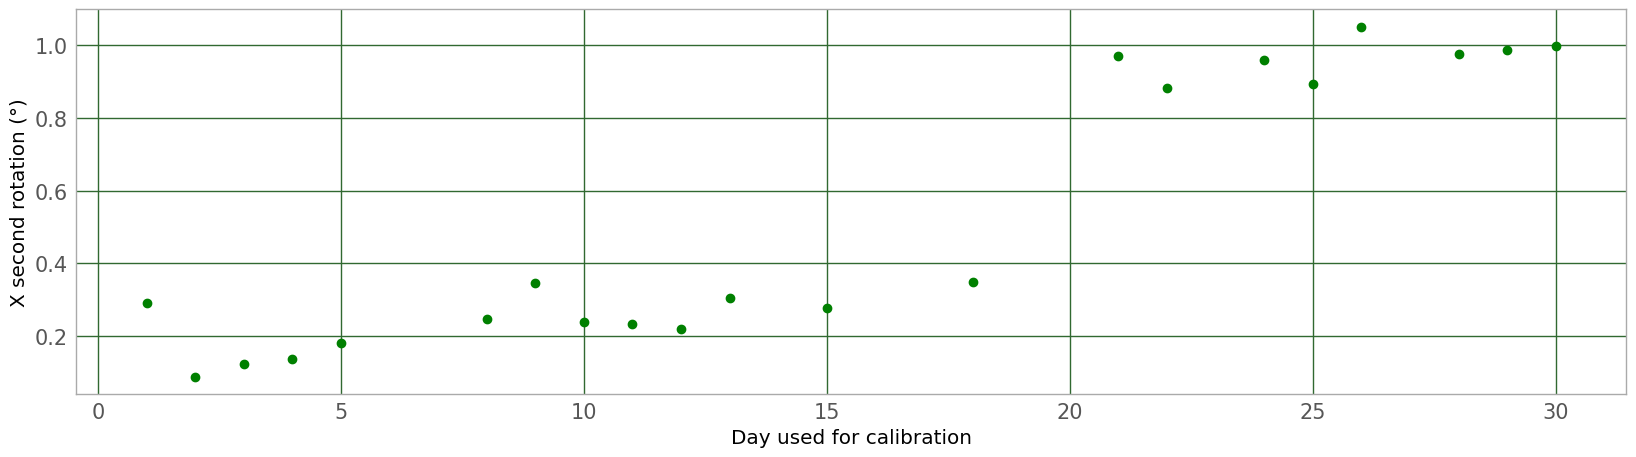

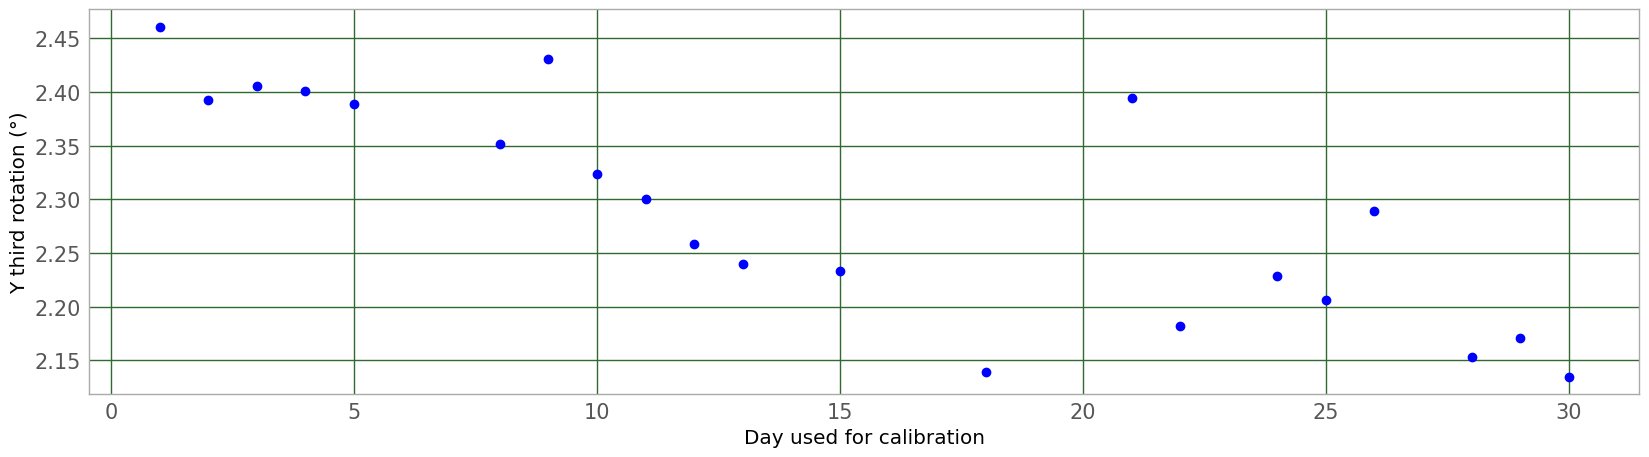

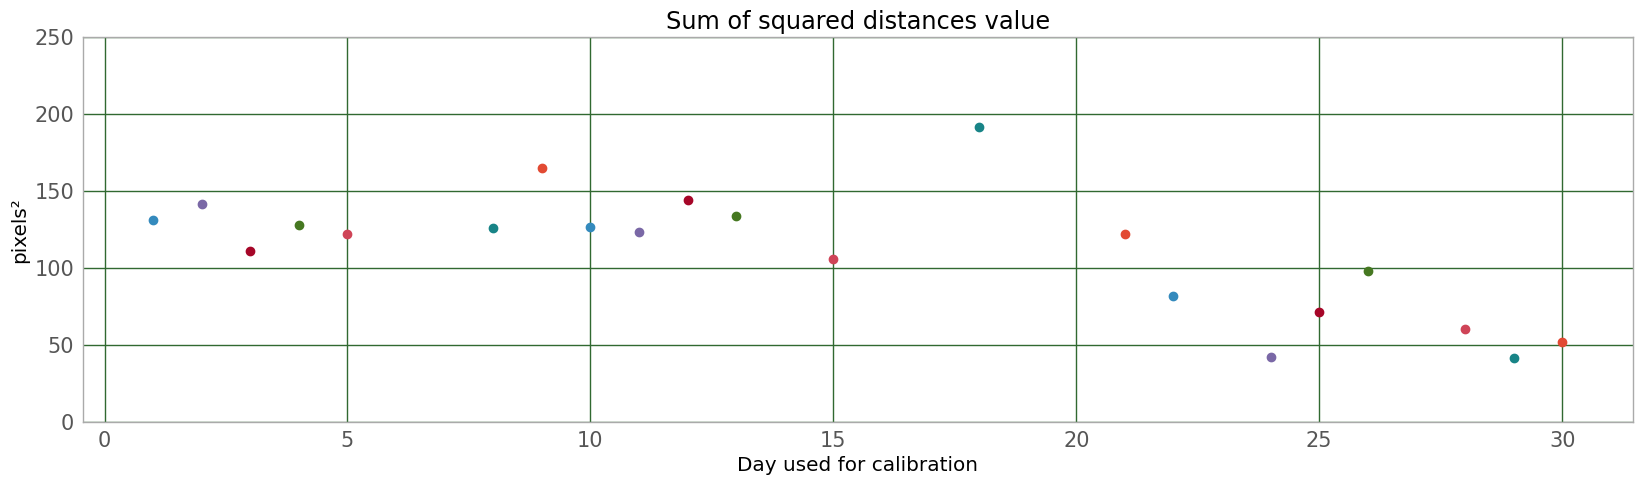

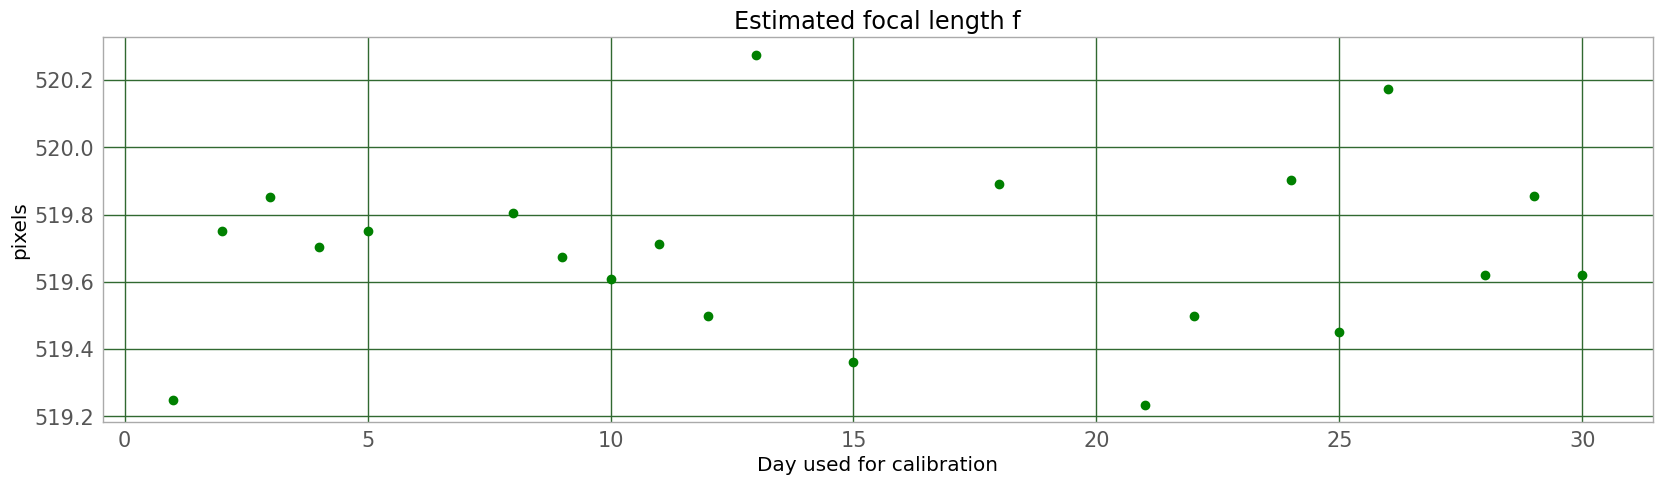

In [32]:
for i in range(liste_resultats.shape[0]):
    xstring="Day used for calibration"
    if liste_resultats[i,2]<200:
        plt.figure(0,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,1][0],c='r')
        plt.title("Rotation values")
        plt.xlabel(xstring)
        plt.ylabel("Z first rotation (°)")
        plt.figure(1,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,1][1],c='g')
        plt.xlabel(xstring)
        plt.ylabel("X second rotation (°)")
        plt.figure(2,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,1][2],c='b')
        plt.xlabel(xstring)
        plt.ylabel("Y third rotation (°)")
        plt.figure(3,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,2])
        plt.title("Sum of squared distances value")
        plt.ylabel("pixels²")

        plt.xlabel(xstring)
        plt.ylim(0,250)
        plt.figure(4,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,3],c='g')
        plt.title("Estimated focal length f")
        plt.xlabel(xstring)
        plt.ylabel("pixels")


### Find best day that minimize calibration residual error

In [33]:
best_fit=np.argmin(liste_resultats[:,2])

In [34]:
liste_resultats[best_fit]

array(['2022-08-27', array([-135.74621047,    0.9878257 ,    2.17118436]),
       41.70160970764056, 519.856177534171], dtype=object)

In [35]:
choosen_date=liste_resultats[best_fit,0]

#### Plot results

In [36]:
def plot_results(centroides,centroides_eph,language='Fr'):
    '''
    Language can be 'Fr' or 'En'
    '''
    if language=='Fr':
        
        plt.figure()
        plt.title("Centroides détectés et course du soleil simulée pour la rotation estimée")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides[i,0],centroides[i,1],marker='+',color="k")#,label="Points Centroides")
            plt.scatter(centroides_eph[i,0],centroides_eph[i,1],marker='x',color="b")#,label="Points Centroides")
            #plt.scatter(centroides_ephm1[i,0],centroides_ephm1[i,1],marker='x',color="g")#,label="Points Centroides")

        plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        legend_elements = [plt.Line2D([0], [0], marker='.', color='w', label='Points de calibration mesures',markerfacecolor='k', markersize=15),plt.Line2D([0], [0], marker='.', color='w', label='Ephemeride par modele inverse',markerfacecolor='b', markersize=15),plt.Line2D([0], [0], marker='o', color='w', label='Centre Optique Estimé',markerfacecolor='r', markersize=15)]
        plt.legend(handles=legend_elements)
        plt.xlabel("Pixels X")
        plt.ylabel("Pixels Y")
        
        
        plt.figure()
        plt.title("Erreur résiduelle")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides[i,0]-centroides_eph[i,0],centroides[i,1]-centroides_eph[i,1],marker='.',color="b")#,label="Points Centroides")
            #plt.scatter(centroides[i,0]-centroides_ephm1[i,0],centroides[i,1]-centroides_ephm1[i,1],marker='.',color="g")#,label="Points Centroides")

            #plt.scatter(,marker='.',color="b")#,label="Points Centroides")
        #plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        legend_elements = [plt.Line2D([0], [0], marker='.', color='b', label='Difference entre position detectée et éphémérides',markerfacecolor='k', markersize=1)]
        plt.legend(handles=legend_elements)
        plt.xlabel("Pixels X")
        plt.ylabel("Pixels Y")
    
    else :
        
        plt.figure()

        plt.title("Detected centroids and simulated sun course on sensor")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides_eph[i,0],centroides_eph[i,1],marker='x',color="b")#,label="Points Centroides")
            plt.scatter(centroides[i,0],centroides[i,1],marker='+',color="k")#,label="Points Centroides")

        plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        legend_elements = [plt.Line2D([0], [0], marker='x', color='b', label='Simulated sun course with estimated orientation', markerfacecolor='b', markersize=15), plt.Line2D([0], [0], marker='+', color='k', label='Measured calibration points', markerfacecolor='k', markersize=15), plt.Line2D([0], [0], marker='o', color='w', label='Camera optical center', markerfacecolor='r', markersize=15)]
        #legend_elements = [plt.Line2D([0], [0], marker='x', color='w', label='Simulated sun\'s course',markerfacecolor='b', markersize=15),plt.Line2D([0], [0], marker='+', color='w', label='Measured calibration points',markerfacecolor='k', markersize=15),plt.Line2D([0], [0], marker='.', color='w', label='Camera\'s optical center',markerfacecolor='r', markersize=15)]
        plt.legend(handles=legend_elements)
        plt.xlabel("X pixels")
        plt.ylabel("Y pixels")

        plt.figure()
        plt.title("Residual error")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides[i,0]-centroides_eph[i,0],centroides[i,1]-centroides_eph[i,1],marker='.',color="k")#,label="Points Centroides")
            #plt.scatter(,marker='.',color="b")#,label="Points Centroides")
        #plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        #legend_elements = [plt.Line2D([0], [0], marker='.', color='w', label='Difference Points de calibration mesures et Ephemerides',markerfacecolor='k', markersize=15)]
        #plt.legend(handles=legend_elements)
        plt.xlabel("X pixels")
        plt.ylabel("Y pixels")

#except ImportError:
#    pass
# <end of examples/doc_parameters_basic.py>

In [61]:
def plot_eph_mes(Psi_Theta_eph,Psi_Theta_mes):
    """
    Cette fonction sert à afficher les deux ensembles de points correspondant aux positions successives du soleil, sous format "azimut - elevation" en radians (elevation nulle -> axe z), d'une part de l'ephemeride et d'autre part des orientations reconstruites.
    """

    
    Psi_Theta_eph=(np.array(Psi_Theta_eph)%(2*np.pi))
    Psi_Theta_mes=np.array(Psi_Theta_mes)%(2*np.pi)

    #plt.scatter(Psi_Theta_eph[:,0],Psi_Theta_eph[:,1],color="r",label='eph')
    #plt.scatter(Psi_Theta_mes[:,0],Psi_Theta_mes[:,1],color="g",label='mes')
    plt.figure(figsize=(20,20))

    ax3=plt.subplot(111, projection='polar', facecolor='#d5de9c')
    ax3.set_title("Orientations in ENU frame, spherical coordinates")

            # radar green, solid grid lines
    plt.rc('grid', color='#316931', linewidth=1, linestyle='-')
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    ax3.set_theta_direction(-1)
    ax3.set_theta_zero_location('N')
    
    
    ax3.plot((Psi_Theta_mes[:,0]),np.degrees(Psi_Theta_mes[:,1]), color='k', lw=1,linestyle='None',marker='+', label='Mesured Sun orientation after inverse rotation')#(Psi_Theta_mes[:,0]-np.pi*0.75)
    ax3.plot(Psi_Theta_eph[:,0],np.degrees(Psi_Theta_eph[:,1]), color='b', lw=1,linestyle='None',marker='x', label='Ephemerids in ENU frame')
    #ax3.plot(Psi_Theta_mes[:20,0],Psi_Theta_mes[:20,1], color='y', lw=3, label='Trajectoire mes')
    #ax3.plot(Psi_Theta_eph[:20,0],Psi_Theta_eph[:20,1], color='b', lw=3, label='Trajectoire eph')
    ax3.legend()
    
    plt.figure()
    plt.title("Orientations in ENU frame, spherical coordinates")
    plt.plot(np.degrees(Psi_Theta_eph[:,1]),'rx',label='Zenith Angle of Ephemerids in ENU frame')
    plt.plot(np.degrees(Psi_Theta_eph[:,0]),'gx',label='Azimut of Ephemerids in ENU frame')
    plt.plot(np.degrees(Psi_Theta_mes[:,1]),'r+',label='Zenith Angle Mesured Sun orientation after inverse rotation')
    plt.plot(np.degrees(Psi_Theta_mes[:,0]),'g+',label='Azimut of Mesured Sun orientation after inverse rotation')
    plt.ylabel('Degrees')
    plt.xlabel('Images over the day')
    plt.legend()

### Use the best date for saving parameters

In [56]:
print("Best date is : ",choosen_date)

x_0,y_0=dist_center[0],dist_center[1]
centroides,PTe=find_centroides_date(choosen_date) # detection of centroids
r,centroides_eph,f=fit_centroides_PTe(centroides,PTe,dist_center=dist_center,save_ENU=True) # fit detected centroids and ephemerids
#get sun detected centroids in ENU frame by rotating by estimated rotation
PTe=PTe*np.pi/180

Best date is :  2022-08-27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4243/4243 [00:32<00:00, 131.14it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 67
    # data points      = 60
    # variables        = 4
    chi-square         = 1.6677e-10
    reduced chi-square = 2.9780e-12
    Akaike info crit   = -1588.52492
    Bayesian info crit = -1580.14755
[[Variables]]
    alpha: -135.746210 +/- 0.01565815 (0.01%) (init = 0)
    beta:   0.98782570 +/- 0.01116000 (1.13%) (init = 0)
    gamma:  2.17118436 +/- 0.01164301 (0.54%) (init = 0)
    f:      519.856178 +/- 0.06633521 (0.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  = +0.5434
    C(gamma, f)     = +0.3721
    C(alpha, gamma) = -0.3497
    C(beta, f)      = +0.3232
Save params !
/scratch/lpoughon/PolarizedDatabase/calib/
Saved !


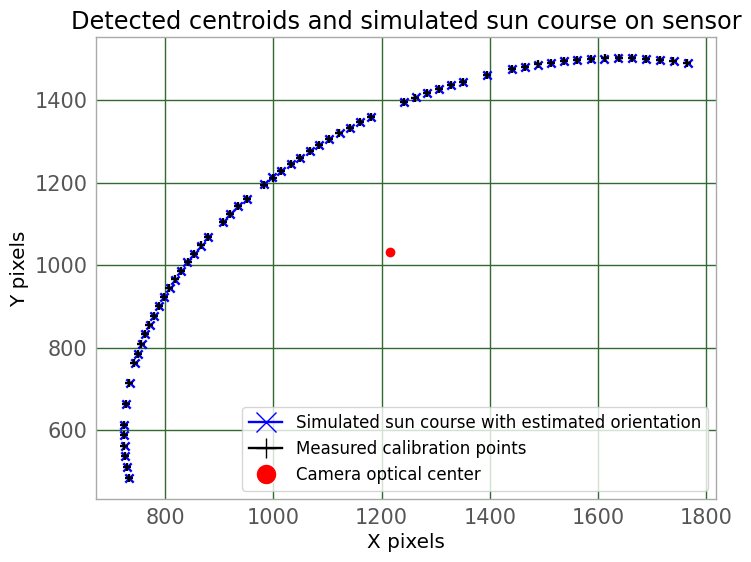

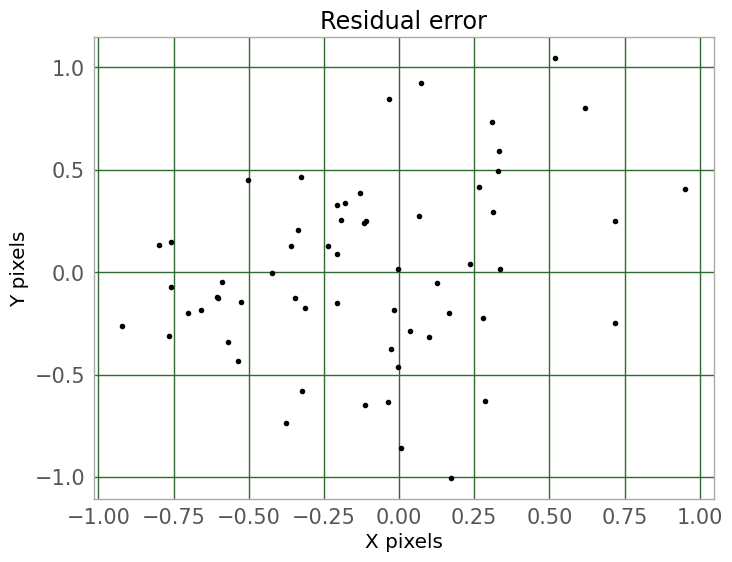

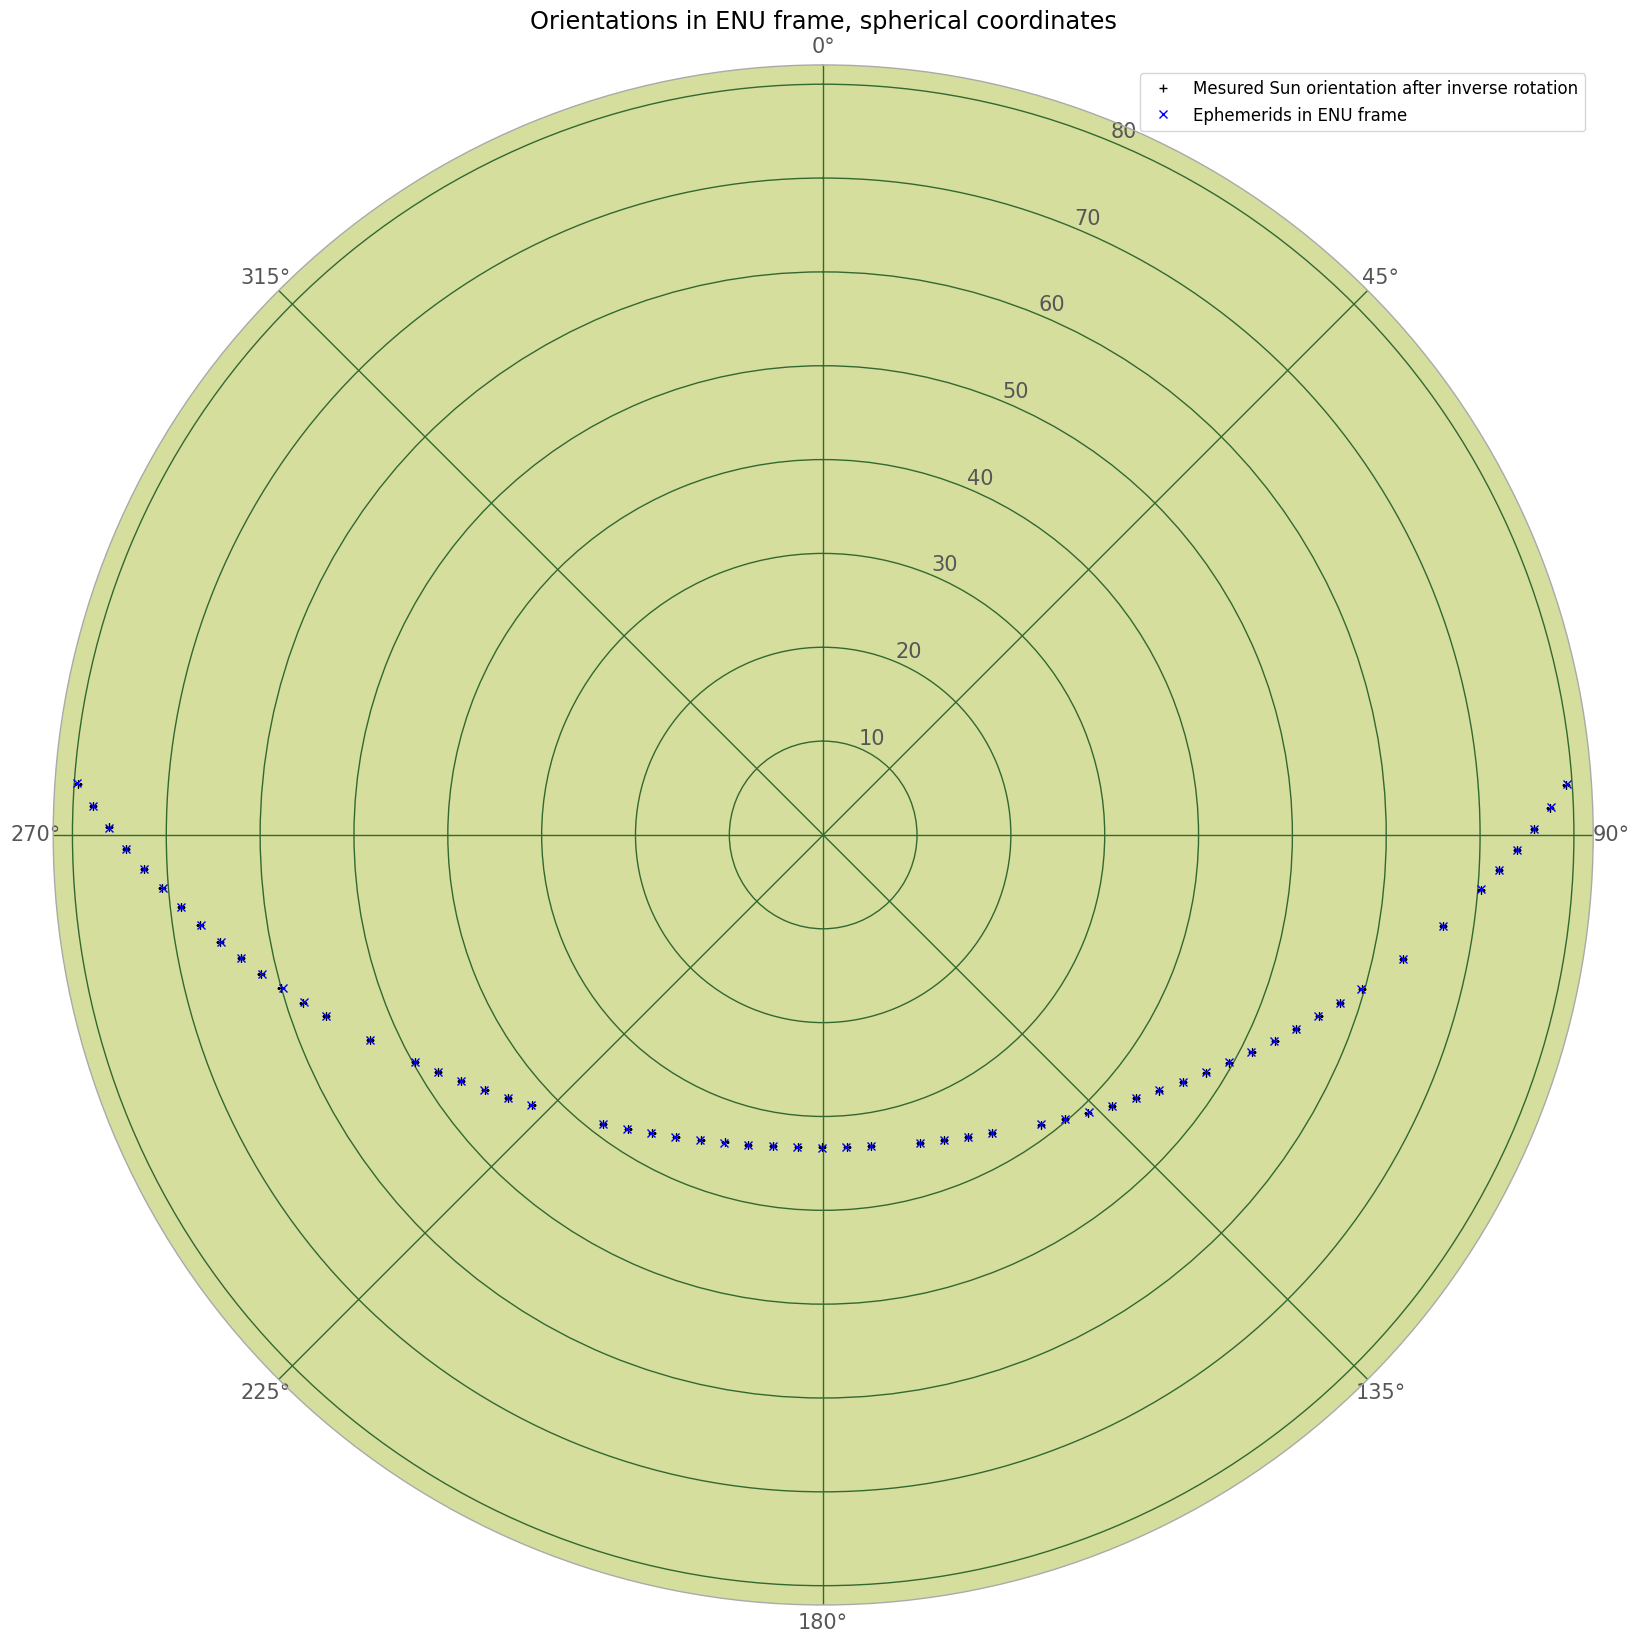

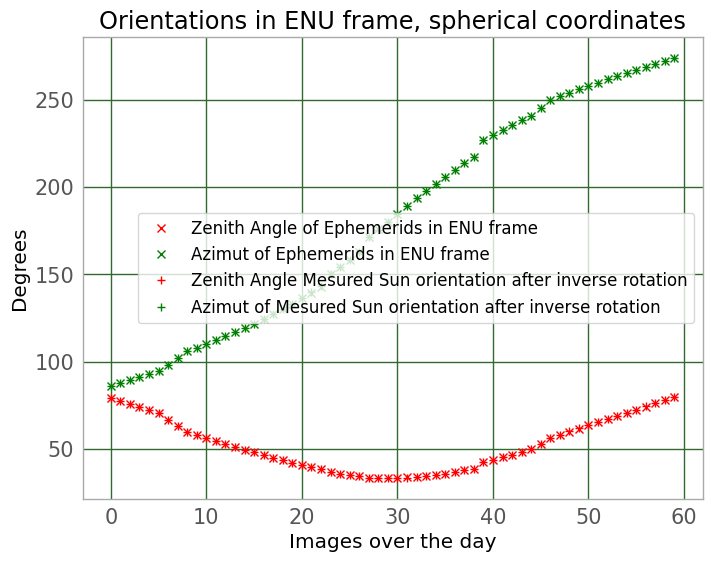

In [62]:

PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f) 
PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T
plot_results(centroides,centroides_eph,language='En')


plot_eph_mes(PTe,PT_rot)

### Show sun detection stability in an animation in order to check any wrong detection

In [63]:
def show_centroides_date(centroides_det,choosen_date,show=False): #detect centroids on images and give corresponding ephemerids, on a given date
    centroides_det=centroides_det.astype('int32')
    centroides_imagettes=[]
    Psi_Theta_eph=[]
    init_somme_image=0
    n_centroides=0
    for i_image in trange(len(dirs_files)):
        for chemins_pos in [dirs_files[i_image]]:
            chemins=np.load(path+chemins_pos)
            i_eme_image=-1
            angles_az=[]
            for chemin in chemins:#chemins_angles_raw_names:
                i_eme_image+=1
                #skip all images but not the one with lower exposure
                if i_eme_image!=5:
                    continue
                if chemin.split('T')[0][-10:]!=choosen_date: #keep only the correct date
                    continue
                png_raw_name=path+chemin.split('ManipeResultats/')[1]
                #print(png_raw_name)
                #liste_expo=np.load(png_raw_name+"liste_expo"+'.npy')
                #liste_angles=np.load(png_raw_name+"liste_angles"+'.npy')
                #taille_liste_angles=liste_angles.shape[1]#361
                #config_monture=np.load(png_raw_name+"config_monture.npy")
                (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chemin.split('ManipeResultats/')[1])
                if 90-Theta_sun<10:continue #If the sun is too low on horizon


                image=np.load(png_raw_name+str(i_eme_image)+'.npy').astype('int64')
                if init_somme_image==0:
                    init_somme_image=1
                    somme_image=image.copy()
                else:
                    somme_image=somme_image+image
                taille_imagette=50
                centroides_imagettes.append(image[centroides_det[n_centroides][1]-taille_imagette:centroides_det[n_centroides][1]+taille_imagette,centroides_det[n_centroides][0]-taille_imagette:centroides_det[n_centroides][0]+taille_imagette])
                
                if show:
                    plt.figure()
                    plt.imshow( centroides_imagettes[n_centroides])
                n_centroides+=1
    return centroides_imagettes

In [59]:
centroides.shape

(60, 2)

In [60]:
imagettes=show_centroides_date(centroides,choosen_date)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4243/4243 [00:07<00:00, 539.83it/s]


In [43]:
#process_image(chemin,7)
video = np.array(imagettes)

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML



fig = plt.figure()
im = plt.imshow(video[0])


plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0])

def animate(i):
    im.set_data(video[i])
    #fig.title(results[results[:,3]==0,0])
    #print(i,video[i][600,950])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
#HTML(anim.to_html5_video())
display(HTML(anim.to_jshtml()))